# Query MySQL hypso database using Pandas

In [1]:
import pymysql
import pandas as pd
import warnings

## Establish database connection

In [2]:
dbname="hypso_base"
host="141.89.96.158"
user="********"
password="*********"

In [3]:
conn = pymysql.connect(host=host, user=user, passwd=password, db=dbname)

## Query gauge locations

`'h'` is for hydrological gauge (i.e. runoff), `'m'` for meteorological/climate gauge. The follwoing query returns all runoff gauges.

In [4]:
warnings.simplefilter("ignore")

In [6]:
sql = "SELECT * FROM locations WHERE id_pargroup='h'"
df = pd.read_sql(sql, conn, index_col=None, coerce_float=True, params=None, parse_dates=None, columns=None) 
df.head()

,id,id_org,name,x,y,elev,id_coordsys,id_elevsys,id_opr,id_pargroup,lat,lon
0,1,0040670,Rangendingen/Starzel,3491878.0,5360743.0,414.00000,3,1,2,h,48.3854,8.89033
1,2,0000462,Bad Imnau/Eyach,3483098.0,5363218.0,390.29001,3,1,2,h,48.4075,8.77168
2,3,0076149,Balingen/Eyach,3489398.0,5349149.0,502.50000,3,1,2,h,48.2811,8.85713
3,4,0004408,Owingen/Eyach,3487784.0,5355737.0,446.42999,3,1,1,h,48.3403,8.83519
4,5,0003426,Talhausen/Glems,3505019.0,5419987.0,210.92000,3,1,1,h,48.9183,9.06849


But which rivers do these gauges belong to (Except that the name is given after the `/`)?

In [7]:
sql = \
"""
SELECT locations.id, locations.name, locations.id_pargroup, gageattributes.id_river
FROM locations
RIGHT JOIN gageattributes ON locations.id = gageattributes.id_loc;
"""
df = pd.read_sql(sql, conn, index_col=None, coerce_float=True, params=None, parse_dates=None, columns=None) 
df.head()

,id,name,id_pargroup,id_river
0,1,Rangendingen/Starzel,h,1
1,2,Bad Imnau/Eyach,h,2
2,3,Balingen/Eyach,h,2
3,4,Owingen/Eyach,h,2
4,485,Eyachmuehle/Eyach,h,2


You can develop some more complex SQL in order to join the river name from table `rivers`. I'll do it later, maybe. Or not.

## Query observations

Now get the actual observations by querying that table. In the following example, we query all discharge values from runoff gauge "Rangendingen" (see above). The `id_par='q'` is, in this case, redundant, because the runoff gauges only have observations of `q`. 

In [8]:
sql = \
"""
SELECT t0, val
FROM observations
WHERE id_loc=1 AND id_par='q'
"""
df = pd.read_sql(sql, conn, index_col=None, coerce_float=True, params=None, parse_dates=None, columns=None) 
df.head()

,t0,val
0,1995-12-31 23:00:00,1.26
1,1996-01-01 00:00:00,1.26
2,1996-01-01 01:00:00,1.26
3,1996-01-01 02:00:00,1.26
4,1996-01-01 03:00:00,1.26


In [9]:
%matplotlib notebook

In [10]:
df['t0'] = pd.to_datetime(df['t0'])

<IPython.core.display.Javascript object>


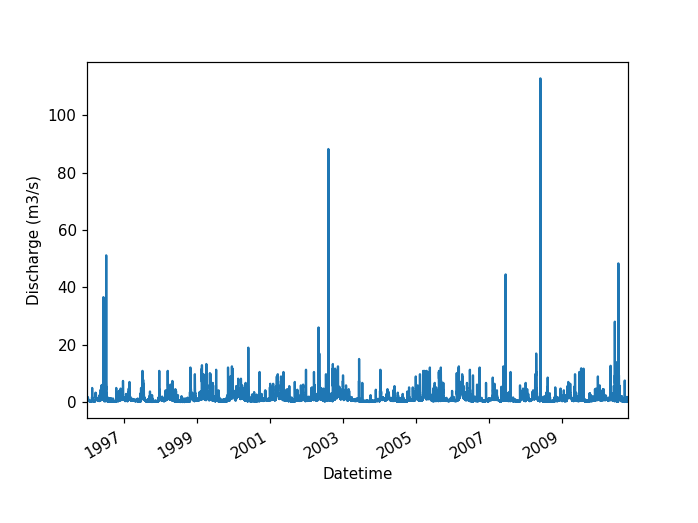

In [11]:
p = df.plot("t0", "val", legend=False)
p.set_xlabel("Datetime")
p.set_ylabel("Discharge (m3/s)")

What is `q`, by the way? And what other paramters are there?

In [12]:
sql = \
"""
SELECT *
FROM parameters
"""
df = pd.read_sql(sql, conn, index_col=None, coerce_float=True, params=None, parse_dates=None, columns=None) 
df

,id,id_group,descr,unit
0,a,m,Air pressure,hPa
1,c,m,Cloudiness as percent of covered sky,%
2,h,m,Relative humidity,%
3,p,m,Precipitation,mm
4,q,h,Stream flow,m3/s
5,r,m,Shortwave radiation,W/m2
6,t,m,Air temperature,degree Celsius
7,v,m,Wind speed,m/s


Now, you could iterate over each gauge id and export the results via `df.to_csv`.

## Tidy up

In [13]:
conn.close()